In [1]:
%pip install tensorflow-hub
%pip install tensorflow
%pip install matplotlib
%pip install numpy
%pip install pillow
%pip install image
%pip install Image
%pip install imageio

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from PIL import Image
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
def tensor2image(tensor):
  tensor = np.array(tensor*255, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)


def load_image(image_path):
  max_dim = 512
  img = tf.io.read_file(image_path)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  #Change shape of image to our size
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

<h1>Single Image Section

In [4]:
#content_image = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_image = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

#content_image = load_image(content_image)
content_image = load_image('single_image_data/og_imgs/animal_in_field.jpg')
style_image = load_image(style_image)

#Change the size of the content image to match the mask from image segmentation
"""
style_image = tensor2image(style_image).resize((content_image.shape[2], content_image.shape[1]))
style_image.save('/content/style_image.png')
print(style_image.size)
style_image = load_image('/content/style_image.png')
"""


styled_image = model(tf.constant(content_image), tf.constant(style_image))[0]
final_styled_image = tensor2image(styled_image)

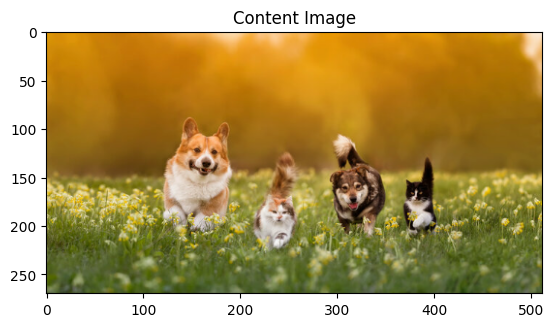

In [5]:
imshow(content_image, 'Content Image')


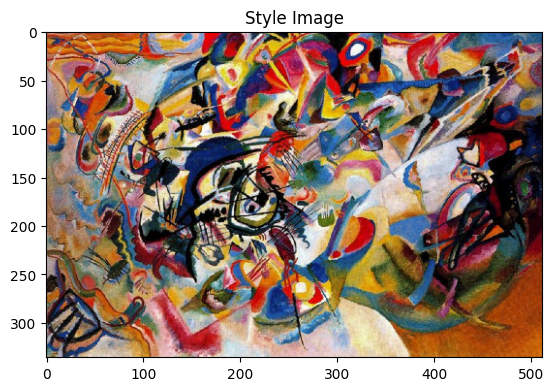

In [6]:
imshow(style_image, 'Style Image')


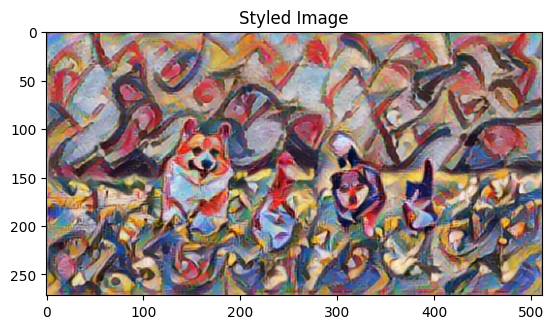

In [7]:
imshow(styled_image, 'Styled Image')
#styled_image = styled_image.numpy()
#styled_image = Image.fromarray((styled_image * 255).astype(np.uint8))
#styled_image = Image.fromarray(styled_image)
final_styled_image.save('single_image_data/finished_styled_image.png')

<h1>Gif Section

In [8]:
from IPython import display
from pathlib import Path
import os
import imageio
    
def gif_to_png(gif_filepath, save_gif_frames_filepath):
        try:
            img = Image.open(gif_filepath)
        except FileNotFoundError:
            print(f"Error: GIF file not found at {gif_filepath}")
            return

        for i in range(img.n_frames):
            img.seek(i)
            filepath = save_gif_frames_filepath + '/frame_' + str(i+1) + '.png'
            img.save(filepath)
            print(f"Frame {i+1} saved as {filepath}")
        return img.n_frames


num_frames = gif_to_png('gif_data/homer.gif', 'gif_data/gif_frames')

Frame 1 saved as gif_data/gif_frames/frame_1.png
Frame 2 saved as gif_data/gif_frames/frame_2.png
Frame 3 saved as gif_data/gif_frames/frame_3.png
Frame 4 saved as gif_data/gif_frames/frame_4.png
Frame 5 saved as gif_data/gif_frames/frame_5.png
Frame 6 saved as gif_data/gif_frames/frame_6.png
Frame 7 saved as gif_data/gif_frames/frame_7.png
Frame 8 saved as gif_data/gif_frames/frame_8.png
Frame 9 saved as gif_data/gif_frames/frame_9.png
Frame 10 saved as gif_data/gif_frames/frame_10.png


In [22]:
def compute_mid_backgrounds(path_to_styles, path_to_save_transition_styles):
  new_count = 0

  for i in range(1, len(os.listdir(path_to_styles))):
    style_image1 = load_image(path_to_styles + "/style" + str(i-1) + ".jpg")
    style_image2 = load_image(path_to_styles + "/style" + str(i) + ".jpg")
    width1, height1 = style_image1.shape[2], style_image1.shape[1]
    width2, height2 = style_image2.shape[2], style_image2.shape[1]

    left_half_img1 = tensor2image(style_image1[:, :, :width1//2])
    right_half_img2 = tensor2image(style_image2[:, :height1, width1//2:])
    total_width = width1//2 + width2//2

    combined_img = Image.new('RGB', (total_width, height1))
    combined_img.paste(left_half_img1, (0, 0))
    combined_img.paste(right_half_img2, (width1//2, 0))

    style_image1 = tensor2image(style_image1)
    style_image2 = tensor2image(style_image2)
    
    style_image1.save(path_to_save_transition_styles +  '/style' + str(new_count) + '.jpg')
    combined_img.save(path_to_save_transition_styles +  '/style' + str(new_count+1) + '.jpg')
    style_image2.save(path_to_save_transition_styles +  '/style' + str(new_count+2) + '.jpg')
    new_count += 3
  
  #At the end now we need to compute a transition from the last style back to the first style for the loop
  style_image1 = load_image(path_to_styles + "/style" + str(len(os.listdir(path_to_styles))-1) + ".jpg")
  style_image2 = load_image(path_to_styles + "/style" + str(0) + ".jpg")
  width1, height1 = style_image1.shape[2], style_image1.shape[1]
  width2, height2 = style_image2.shape[2], style_image2.shape[1]

  left_half_img1 = tensor2image(style_image1[:, :, :width1//2])
  right_half_img2 = tensor2image(style_image2[:, :height1, width1//2:])
  total_width = width1//2 + width2//2

  combined_img = Image.new('RGB', (total_width, height1))
  combined_img.paste(left_half_img1, (0, 0))
  combined_img.paste(right_half_img2, (width1//2, 0))
  
  combined_img.save(path_to_save_transition_styles +  '/style' + str(new_count) + '.jpg')


compute_mid_backgrounds('gif_data/style_images', 'gif_data/transition_style_images')



In [23]:
#Run each frame of the gif through the style changing model

def transfer_style_gif(path_to_gif_frames, path_to_styles, path_to_save_styled_images):
  num_styles = len(os.listdir(path_to_styles))
  for i in range(num_frames):
    print(path_to_gif_frames + '/frame_' + str(i+1) + '.png')
    content_image = load_image(path_to_gif_frames + '/frame_' + str(i+1) + '.png')
    style_image = load_image(path_to_styles + '/style' + str(i%num_styles) + '.jpg')
    styled_image = model(tf.constant(content_image), tf.constant(style_image))[0]
    styled_image = tensor2image(styled_image)

    #Save the styled image in new folder
    styled_image.save(path_to_save_styled_images + '/frame_' + str(i+1) + '.png')

transfer_style_gif('gif_data/gif_frames', 'gif_data/transition_style_images', 'gif_data/styled_images')


gif_data/gif_frames/frame_1.png
gif_data/gif_frames/frame_2.png
gif_data/gif_frames/frame_3.png
gif_data/gif_frames/frame_4.png
gif_data/gif_frames/frame_5.png
gif_data/gif_frames/frame_6.png
gif_data/gif_frames/frame_7.png
gif_data/gif_frames/frame_8.png
gif_data/gif_frames/frame_9.png
gif_data/gif_frames/frame_10.png


In [24]:

def frames2gif(path_to_frames, new_gif_name, path_to_save_gif, duration=100):
  images = []
  for image in os.listdir(path_to_frames):
    images.append(imageio.imread(path_to_frames + image))

  #Can add a duration paramater after loop to something like 500 to slow down the gif
  imageio.mimsave(path_to_save_gif + new_gif_name + '.gif', images, loop=10, duration=duration)

frames2gif('gif_data/styled_images/', '/style_transfered_gif', 'gif_data')


/var/folders/32/_1161bkj3qj12zf3jnzyhtc40000gn/T/ipykernel_99862/967822842.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(path_to_frames + image))


In [25]:
#Compare style-transfered gif with transition styles vs without

#With transition styles
print("\nWith transition styles:")
transfer_style_gif('gif_data/gif_frames', 'gif_data/transition_style_images', 'gif_data/styled_images')
frames2gif('gif_data/styled_images/', '/style_transfered_gif', 'gif_data', duration=500)

#Without transition styles
print("\n\nWithout transition styles:")
transfer_style_gif('gif_data/gif_frames', 'gif_data/style_images', 'gif_data/styled_images')
frames2gif('gif_data/styled_images/', '/style_transfered_gif_without_transition', 'gif_data', duration=500)


With transition styles:
gif_data/gif_frames/frame_1.png
gif_data/gif_frames/frame_2.png
gif_data/gif_frames/frame_3.png
gif_data/gif_frames/frame_4.png
gif_data/gif_frames/frame_5.png
gif_data/gif_frames/frame_6.png
gif_data/gif_frames/frame_7.png
gif_data/gif_frames/frame_8.png
gif_data/gif_frames/frame_9.png
gif_data/gif_frames/frame_10.png


/var/folders/32/_1161bkj3qj12zf3jnzyhtc40000gn/T/ipykernel_99862/967822842.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(path_to_frames + image))




Without transition styles:
gif_data/gif_frames/frame_1.png
gif_data/gif_frames/frame_2.png
gif_data/gif_frames/frame_3.png
gif_data/gif_frames/frame_4.png
gif_data/gif_frames/frame_5.png
gif_data/gif_frames/frame_6.png
gif_data/gif_frames/frame_7.png
gif_data/gif_frames/frame_8.png
gif_data/gif_frames/frame_9.png
gif_data/gif_frames/frame_10.png
